In [3]:
from keras.layers import Input, Dropout, BatchNormalization, CuDNNGRU, CuDNNLSTM, LSTM, Dense, Bidirectional, Activation, AveragePooling2D
from keras.models import Sequential, Model

from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from IPython.display import display
from ipywidgets import IntProgress
from tensorflow import *
from scipy import stats

# import tensorflow_decision_forests 

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, average_precision_score

import matplotlib.pyplot as plt
import scikitplot as skplt
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import optuna as op
import scipy as sp

import time
import io
import os

%matplotlib inline

In [27]:
df_test = pd.read_table("TST.cod")
df_tr = pd.read_table("TRNcod.xls") ##! <<<<<<<<<<<< READ_EXCEL NÃO FUNCIONA

In [31]:
loss_function = keras.losses.SparseCategoricalCrossentropy()

patienceCallback = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 20)

def extract_final_losses(history):
    """Função para extrair o melhor loss de treino e validação.
    
    Argumento(s):
    history -- Objeto retornado pela função fit do keras.
    
    Retorno:
    Dicionário contendo o melhor loss de treino e de validação baseado 
    no menor loss de validação.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    idx_min_val_loss = np.argmin(val_loss)
    return {'train_loss': train_loss[idx_min_val_loss], 'val_loss': val_loss[idx_min_val_loss]}

def plot_training_error_curves(history):
    """Função para plotar as curvas de erro do treinamento da rede neural.
    
    Argumento(s):
    history -- Objeto retornado pela função fit do keras.
    
    Retorno:
    A função gera o gráfico do treino da rede e retorna None.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Error Curves', xlabel='Epochs', ylabel='Loss (MSE)')
    ax.legend()
    plt.show()

def compute_performance_metrics(y, y_pred_class, y_pred_scores=None):
    accuracy = accuracy_score(y, y_pred_class)
    recall = recall_score(y, y_pred_class)
    precision = precision_score(y, y_pred_class)
    f1 = f1_score(y, y_pred_class)
    performance_metrics = (accuracy, recall, precision, f1)
    if y_pred_scores is not None:
        skplt.metrics.plot_ks_statistic(y, y_pred_scores)
        plt.show()
        y_pred_scores = y_pred_scores[:, 1]
        auroc = roc_auc_score(y, y_pred_scores)
        aupr = average_precision_score(y, y_pred_scores)
        performance_metrics = performance_metrics + (auroc, aupr)
    return performance_metrics

def print_metrics_summary(accuracy, recall, precision, f1, auroc=None, aupr=None):
    print()
    print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy))
    print("{metric:<18}{value:.4f}".format(metric="Recall:", value=recall))
    print("{metric:<18}{value:.4f}".format(metric="Precision:", value=precision))
    print("{metric:<18}{value:.4f}".format(metric="F1:", value=f1))
    if auroc is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=auroc))
    if aupr is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUPR:", value=aupr))

def createMLPModel(layers=[Dense(64, activation = 'relu'),
                           Dense(32, activation = 'sigmoid'),
                           Dense(10, activation = 'sigmoid'),
                           Dense(2, activation = 'sigmoid'),],
                   file_path='./training_default',
                   loss=loss_function,
                   metrics=['accuracy'],
                   optimizer='nadam'
                   ):
  """Returns an MLP model based on params

  Args:
      layers (list, optional): list of layers. Defaults to [Dense(64, activation = 'relu'), Dense(32, activation = 'sigmoid'), Dense(10, activation = 'sigmoid'), Dense(2, activation = 'sigmoid'),].
      file_path (str, optional): path to save the weights. Defaults to './training_default'.
      loss (loss function, optional): loss function used by the model. Defaults to loss_function.
      metrics (list, optional): list of metrics to return on verbose. Defaults to ['accuracy'].
  """
  new_model = Sequential(layers=layers)


  cb = tf.keras.callbacks.ModelCheckpoint(filepath=file_path,
                                        save_weights_only=True,
                                        verbose=0)
  
  new_model.compile(optimizer = optimizer,
      loss = loss,
      metrics=metrics)
  
  return new_model


## Tratamento dos dados

In [29]:
if "IND_BOM_1_1" in df_tr:
    df_tr = df_tr.drop(columns = ["IND_BOM_1_1"])
if "INDEX" in df_tr:
    df_tr = df_tr.drop(columns = ["INDEX"])
if "IND_BOM_1_2" in df_tr:
    df_tr = df_tr.rename(columns = {"IND_BOM_1_2": "CLASSE_INDIV"})

#0 = Classe 1
#1 = Classe 2

In [30]:
df_tr_class_1 = df_tr[df_tr['CLASSE_INDIV'] == 0]
df_tr_class_2 = df_tr[df_tr['CLASSE_INDIV'] == 1]

df_tr_class_1_a = df_tr_class_1.sample(frac = 0.66)
df_tr_class_1_b = df_tr_class_1.drop(df_tr_class_1_a.index)

df_tr_class_2_a = df_tr_class_2.sample(frac = 0.66)
df_tr_class_2_b = df_tr_class_2.drop(df_tr_class_2_a.index)

df_tr_class_2_a = pd.concat([df_tr_class_2_a,
                     df_tr_class_2_a.sample(len(df_tr_class_1_a) - len(df_tr_class_2_a))],
                     ignore_index = True,
                     sort = False)

df_tr_class_2_b = pd.concat([df_tr_class_2_b,
                     df_tr_class_2_b.sample(len(df_tr_class_1_b) - len(df_tr_class_2_b))],
                     ignore_index = True,
                     sort = False)

df_trein = pd.concat([df_tr_class_1_a, df_tr_class_2_a])
df_valid = pd.concat([df_tr_class_1_b, df_tr_class_2_b])

df_tr_class_1 = None
df_tr_class_2 = None

df_tr_class_1_a = None
df_tr_class_1_b = None
df_tr_class_2_a = None
df_tr_class_2_b = None

df_trein = shuffle(df_trein).reset_index().drop(columns = ["index"])
df_valid = shuffle(df_valid).reset_index().drop(columns = ["index"])

Dados de treinamento e validação

In [8]:
df_treinX = df_trein.drop(columns = ["CLASSE_INDIV"])
df_treinY = df_trein["CLASSE_INDIV"]
df_validX = df_valid.drop(columns = ["CLASSE_INDIV"])
df_validY = df_valid["CLASSE_INDIV"]

Dados de teste

In [9]:
if "IND_BOM_1_1" in df_test:
    df_test = df_test.drop(columns = ["IND_BOM_1_1"])
if "INDEX" in df_test:
    df_test = df_test.drop(columns = ["INDEX"])
if "IND_BOM_1_2" in df_test:
    df_test = df_test.rename(columns = {"IND_BOM_1_2": "CLASSE_INDIV"})


df_test_x = df_test.drop(columns = ["CLASSE_INDIV"])
df_test_y = df_test["CLASSE_INDIV"]


In [ ]:
MLPmodel = Sequential([
    Dense(246, activation = 'relu'),
    Dense(10, activation = 'sigmoid'),
    ])

tf.keras.optimizers.Adam(
    learning_rate=0.01
)

loss_function = keras.losses.SparseCategoricalCrossentropy()

MLPmodel.compile(optimizer = 'adam',
      loss = loss_function,
      metrics=['accuracy'],
      )

file_path = 'training_2/cp.ckpt'
file_dir = os.path.dirname(file_path)

cb = tf.keras.callbacks.ModelCheckpoint(filepath=file_path,
                                        save_weights_only=True,
                                        verbose=0)

MLPmodel.fit(df_treinX, df_treinY, epochs = 10000, 
          batch_size = 2000, callbacks = [patienceCallback, cb],  
          validation_data = (df_validX, df_validY),
          verbose=2,

          )



### Acurácia muito baixa, precisamos passar pelo processo de tunagem

In [9]:
MLPmodel_2 = Sequential([
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'sigmoid'),
    Dense(10, activation = 'sigmoid'),
    Dense(10, activation = 'sigmoid'),
    ])

loss_function = keras.losses.SparseCategoricalCrossentropy()


file_path = 'training_3/cp.ckpt'
file_dir = os.path.dirname(file_path)


cb = tf.keras.callbacks.ModelCheckpoint(filepath=file_path,
                                        save_weights_only=True,
                                        verbose=0)

MLPmodel_2.compile(optimizer = 'nadam',
      loss = loss_function,
      metrics=['accuracy'])



MLPmodel_2.fit(df_treinX, df_treinY, epochs = 1, 
          batch_size = 2000, callbacks = [patienceCallback],  
          validation_data = (df_validX, df_validY),
          verbose=2,
          )

169/169 - 2s - loss: 0.7983 - accuracy: 0.5813 - val_loss: 0.6627 - val_accuracy: 0.6212 - 2s/epoch - 15ms/step


In [10]:
MLPmodel_2.load_weights(file_path) ## carregar os pesos do treinamento anterior

In [11]:
loss, acc = MLPmodel_2.evaluate(df_test_x, df_test_y, verbose=2)

4055/4055 - 3s - loss: 1.4691 - accuracy: 0.5992 - 3s/epoch - 660us/step


In [13]:
predictions = MLPmodel_2.predict(df_test_x)
test_results = predictions.argmax(axis=-1)
test_y = df_test_y.to_list()
stats.ks_2samp(test_y, test_results)

In [ ]:
MLPmodel_4 = Sequential([
    Dense(64, activation = 'relu'),
    Dense(32, activation = 'sigmoid'),
    Dense(10, activation = 'sigmoid'),
    Dense(2, activation = 'sigmoid'),
    ])

file_path = 'training_4/cp.ckpt'
file_dir = os.path.dirname(file_path)

loss_function = keras.losses.SparseCategoricalCrossentropy()

cb = tf.keras.callbacks.ModelCheckpoint(filepath=file_path,
                                        save_weights_only=True,
                                        verbose=0)


MLPmodel_4.compile(optimizer = 'nadam',
      loss = loss_function,
      metrics=['accuracy'])

MLPmodel_4.fit(df_treinX, df_treinY, epochs = 10000, 
          batch_size = 1000, callbacks = [patienceCallback, cb],  
          validation_data = (df_validX, df_validY))

In [ ]:
tf.keras.optimizers.Nadam(
    learning_rate=0.02
)

MLPmodel_5 = createMLPModel(layers=[Dense(64,activation="softmax"),
                             Dense(32, activation="softmax"),
                             Dense(16, activation='relu'),
                             Dense(2, activation='sigmoid')],
                             optimizer='adam',
                             loss=loss_function,
                             file_path='./training_dropout',
                             )

MLPmodel_5.fit(df_treinX, df_treinY, epochs = 10000, 
          batch_size = 1000, callbacks = [patienceCallback, cb],  
          validation_data = (df_validX, df_validY),
          verbose=2)

In [ ]:
MLPmodel_6 = createMLPModel(layers=[
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'sigmoid'),
    Dense(10, activation = 'sigmoid'),
    Dense(2, activation = 'sigmoid'),
    ],
    file_path='training_6/cp.ckpt'
    )


MLPmodel_6.fit(df_treinX, df_treinY, epochs = 10000, 
          batch_size = 2000, callbacks = [patienceCallback, cb],  
          validation_data = (df_validX, df_validY),
          verbose=2,
          )

In [ ]:
MLPmodel_7 = createMLPModel(layers=[
    Dense(256, activation = 'relu'),
    Dense(128, activation = 'sigmoid'),
    Dense(64, activation = 'sigmoid'),
    Dense(2, activation = 'sigmoid'),
    ],
    file_path='training_7/cp.ckpt'
    )


MLPmodel_7.fit(df_treinX, df_treinY, epochs = 10000, 
          batch_size = 2000, callbacks = [patienceCallback, cb],  
          validation_data = (df_validX, df_validY),
          verbose=2,
          )

In [ ]:
# predictions = MLPmodel_7.predict(df_test_x)
# test_results = predictions.argmax(axis=-1)
# test_y = df_test_y.to_list()
# stats.ks_2samp(test_y, test_results)

In [ ]:
MLPmodel_8 = createMLPModel(layers=[
    Dense(256, activation = 'relu'),
    Dropout(rate=0.15),
    Dense(128, activation = 'sigmoid'),
    Dropout(rate=0.1),
    Dense(64, activation = 'sigmoid'),
    Dropout(rate=0.1),
    Dense(2, activation = 'sigmoid'),
    ],
    )

file_path='./training_8/cp.ckpt'
cb = tf.keras.callbacks.ModelCheckpoint(filepath=file_path,
                                        save_weights_only=True,
                                        verbose=0)


history = MLPmodel_8.fit(df_treinX, df_treinY, epochs = 10000, 
          batch_size = 2000, callbacks = [patienceCallback, cb],  
          validation_data = (df_validX, df_validY),
          verbose=2,
          )

In [16]:
MLPmodel_9 = createMLPModel(layers=[
    Dense(256, activation = 'relu'),
    Dropout(rate=0.15),
    Dense(128, activation = 'relu'),
    Dropout(rate=0.1),
    Dense(64, activation = 'sigmoid'),
    Dropout(rate=0.1),
    Dense(2, activation = 'sigmoid'),
    ],
    )

file_path='./training_9/cp.ckpt'

cb = tf.keras.callbacks.ModelCheckpoint(filepath=file_path,
                                        save_weights_only=True,
                                        verbose=0)

history = MLPmodel_9.fit(df_treinX, df_treinY, epochs = 10000, 
          batch_size = 2000, callbacks = [patienceCallback, cb],  
          validation_data = (df_validX, df_validY),
          verbose=2,
          )

In [19]:
MLPmodel_9.load_weights(file_path)

4055/4055 [==============================] - 3s 660us/step
Matriz de confusão no conjunto de teste:
array([[55378, 29655],
       [20592, 24108]], dtype=int64)

Performance no conjunto de teste:


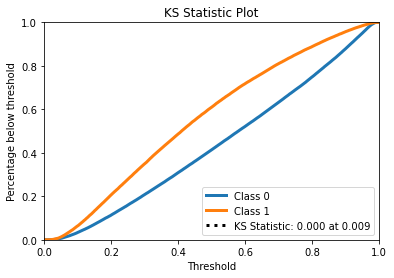


Accuracy:         0.6127
Recall:           0.5393
Precision:        0.4484
F1:               0.4897
AUROC:            0.3670
AUPR:             0.2681


In [35]:
y_pred_scores = MLPmodel_9.predict(df_test_x)
y_pred_class = y_pred_scores.argmax(axis=-1)
y_pred_scores_0 = 1 - y_pred_scores
y_pred_scores = np.concatenate([y_pred_scores_0, y_pred_scores], axis=1)

## Matriz de confusão
print('Matriz de confusão no conjunto de teste:')
print(confusion_matrix(df_test_y, y_pred_class))

print('\nPerformance no conjunto de teste:')
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(df_test_y.to_list(), y_pred_class, y_pred_scores)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

In [34]:
df_test_y.size, len(y_pred_class), len(y_pred_scores)

(129733, 129733, 129733)

In [ ]:
RFmodel = tfdf.keras.RandomForestModel()

RFmodel.fit(tfdf.keras.pd_dataframe_to_tf_dataset(df_trein, label = "CLASSE_INDIV"), 
          callbacks = [patienceCallback])

In [ ]:
RFmodel.summary()

In [ ]:
RFmodel.compile(metrics = ["accuracy"])
RFmodel.evaluate(tfdf.keras.pd_dataframe_to_tf_dataset(df_valid, label = "CLASSE_INDIV"))

In [16]:
tfdf.model_plotter.plot_model_in_colab(RFmodel, tree_idx=0, max_depth = 3)

### Gradient Boosting

In [50]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, r2_score, matthews_corrcoef 

from numpy import round


In [68]:
gb_model = GradientBoostingRegressor(n_estimators=500, max_depth=5, random_state=42, verbose=1) # 1st try
gb_model_2 = GradientBoostingRegressor(n_estimators=248, max_depth=5, random_state=42, verbose=1, )

In [69]:
gb_model_2.fit(df_treinX, df_treinY)

      Iter       Train Loss   Remaining Time 
         1           0.2460           69.56m
         2           0.2428           69.80m
         3           0.2400           67.99m
         4           0.2376           69.89m


KeyboardInterrupt: 

In [60]:
y_pred = round(gb_model.predict(df_test_x))

In [61]:
accuracy = accuracy_score(df_test_y.to_list(), y_pred)

In [63]:

accuracy

0.6533187392567812

In [64]:
import pickle

with open('./gradient_boosting/model.pkl', 'wb') as file:
    pickle.dump(gb_model, file)
  

In [66]:
with open('./gradient_boosting/model.pkl', 'rb') as file:
    model = pickle.load(file)



array([0., 0., 1., ..., 0., 1., 0.])

In [67]:
round(model.predict(df_test_x))


array([0., 0., 1., ..., 0., 1., 0.])